# Time series aggregation

Veronica Andreo  
2024-07-23

In this second time series tutorial, we will go through different ways
of performing **aggregations**. Temporal aggregation is a very common
task when working with time series as it allows us to summarize
information and find patterns of change both in space and time.

> **Setup**
>
> This tutorial can be run locally or in Google Colab. However, make
> sure you install GRASS GIS 8.4+, download the sample data and set up
> your project as explained in the
> [first](time_series_management_and_visualization.qmd) time series
> tutorial.

There are two main tools to do time series aggregations in GRASS:
[t.rast.aggregate](https://grass.osgeo.org/grass-stable/manuals/t.rast.aggregate.html)
and
[t.rast.series](https://grass.osgeo.org/grass-stable/manuals/t.rast.series.html).
We’ll demonstrate their usage in the upcoming sections.

## Aggregation with granularity

**Granularity** is the greatest common divisor of the temporal extents
(and possible gaps) of all maps in a space-time dataset. To perform time
series aggregation with granularity, we use
[t.rast.aggregate](https://grass.osgeo.org/grass-stable/manuals/t.rast.aggregate.html).
This tool allows us to aggregate our time series into larger
granularities, i.e., from hourly to daily, from daily to weekly,
monthly, etc. It also permits to aggregate with *ad hoc* granularities
like 3 minutes, 5 days, 3 months, etc. Supported aggregate methods
include average, minimum, maximum, median, etc. See the
[r.series](https://grass.osgeo.org/grass-stable/manuals/r.series.html)
manual page for more details.

If you are working with data representing absolute time,
*t.rast.aggregate* will shift the start date for each aggregation
process depending on the provided temporal granularity as follows:

-   *years*: will start at the first of January, hence 14-08-2012
    00:01:30 will be shifted to 01-01-2012 00:00:00
-   *months*: will start at the first day of a month, hence 14-08-2012
    will be shifted to 01-08-2012 00:00:00
-   *weeks*: will start at the first day of a week (Monday), hence
    14-08-2012 01:30:30 will be shifted to 13-08-2012 01:00:00
-   *days*: will start at the first hour of a day, hence 14-08-2012
    00:01:30 will be shifted to 14-08-2012 00:00:00
-   *hours*: will start at the first minute of a hour, hence 14-08-2012
    01:30:30 will be shifted to 14-08-2012 01:00:00
-   *minutes*: will start at the first second of a minute, hence
    14-08-2012 01:30:30 will be shifted to 14-08-2012 01:30:00

The specification of the temporal relation between the aggregation
intervals and the raster map layers to be aggregated is always
formulated from the aggregation interval viewpoint. By default, it is
set to the *contains* relation to aggregate all maps that are temporally
within an aggregation interval.

> **Temporal topology**
>
> **Temporal topology** refers to the temporal relations among time
> intervals or instances in different time series. They are mostly
> useful when sampling one STRDS with another (see
> [t.sample](https://grass.osgeo.org/grass-stable/manuals/t.sample.html)
> manual). Some examples of temporal relations are *start, equal,
> during, contain, overlap,* etc. See below a graphic representation of
> relations and sampling taken from Gebbert and Pebesma (2014). Note
> that A1 starts in S1, B3 is during S3, B4 equals S4, B1 overlaps S1.
>
> <figure>
> 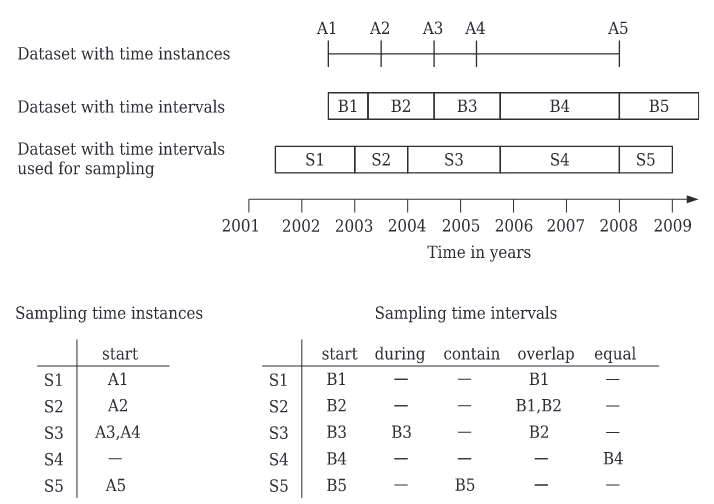 alt="Temporal sampling and relations" />
> <figcaption aria-hidden="true">Temporal sampling and
> relations</figcaption>
> </figure>

### Monthly and seasonal averages

To demonstrate the basic usage of *t.rast.aggregate*, let’s create
monthly and seasonal time series starting from the `lst_daily` time
series we created in the [time series
management](time_series_management_and_visualization.qmd) tutorial.

In [2]:
# Daily to monthly
gs.run_command("t.rast.aggregate",
                input="lst_daily",
                method="average",
                granularity="1 months",
                basename="lst_avg",
                output="lst_monthly",
                suffix="gran",
                nprocs=4)

In [3]:
# Daily to (sort of) seasonal
gs.run_command("t.rast.aggregate",
                input="lst_daily",
                method="average",
                granularity="3 months",
                basename="lst_avg",
                output="lst_seasonal",
                suffix="gran",
                nprocs=4)

If we would like to follow the so called [*meteorological
seasons*](https://en.wikipedia.org/wiki/Season#Meteorological), i.e.,
that spring started with March, then we could have used the *where*
option to shift the starting point of the aggregation period as follows:
`where="start_time >= '2013-03-01 00:00:00'"`.

Let’s compare the granularities using the timeline plot…

In [4]:
!g.gui.timeline lst_monthly,lst_seasonal

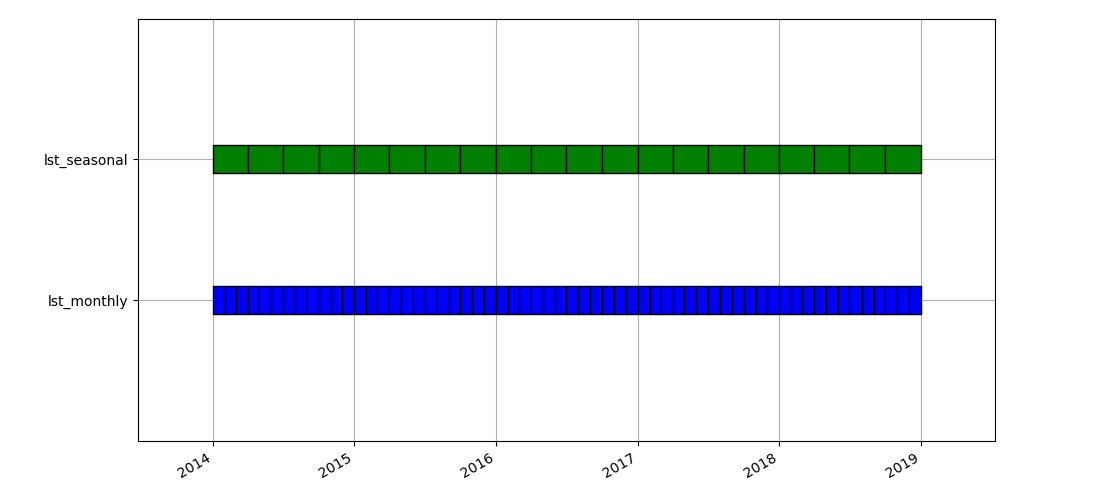

and use `grass.jupyter` to create a nice animation of the seasonal time
series:

In [5]:
lstseries = gj.TimeSeriesMap()
lstseries.add_raster_series("lst_seasonal", fill_gaps=False)
lstseries.d_legend(color="black", at=(5, 50, 2, 6))
lstseries.show()

In [6]:
# Optionally, write out to animated GIF
lstseries.save("lstseries.gif")

For astronomical seasons, i.e., those defined by solstices and
equinoxes, we can use
[t.rast.aggregate.ds](https://grass.osgeo.org/grass-stable/manuals/t.rast.aggregate.ds.html)
as in [this
example](https://grasswiki.osgeo.org/wiki/Temporal_data_processing/seasonal_aggregation),
or for an approximate result:

In [7]:
gs.run_command("t.rast.aggregate",
                input="lst_daily",
                method="average",
                where="start_time >= '2013-03-21 00:00:00'",
                granularity="3 months",
                basename="lst_avg",
                output="lst_seasonal",
                suffix="gran",
                nprocs=4)

In [8]:
# Check info
gs.read_command("t.info", input="lst_seasonal")

In [9]:
# Check raster maps in the STRDS
gs.run_command("t.rast.list", input="lst_seasonal")

### Spring warming

We define spring warming as the velocity with which temperature
increases from winter into spring and we can approximate it as the
linear regression slope among LST values of February, March and April.
Let’s see how to use *t.rast.aggregate* to estimate yearly spring
warming values.

In [10]:
# Define list of months
months = [f"{m:02d}" for m in range(2, 5)]
print(months)

In [11]:
# Annual spring warming
gs.run_command("t.rast.aggregate",
               input="lst_daily",
               output="annual_spring_warming",
               basename="spring_warming",
               suffix="gran",
               method="slope",
               granularity="1 years",
               where=f"strftime('%m',start_time)='{months[0]}' or strftime('%m',start_time)='{months[1]}' or strftime('%m', start_time)='{months[2]}'")

In [12]:
# Check raster maps in the STRDS
gs.run_command("t.rast.list", input="annual_spring_warming")

In [13]:
spring_warming = gj.TimeSeriesMap()
spring_warming.add_raster_series("annual_spring_warming", fill_gaps=False)
spring_warming.d_legend(color="black", at=(5, 50, 2, 6))
spring_warming.show()

> **Question**
>
> How would you obtain the average spring warming over the whole time
> series?
>
> ``` python
> # Average spring warming
> gs.run_command("t.rast.series",
>                input="annual_spring_warming",
>                output="avg_spring_warming",
>                method="average")
>                
> # Display raster map with interactive class
> spw_map = gj.InteractiveMap(width = 500, use_region=True, tiles="CartoDark")
> spw_map.add_raster("avg_spring_warming")
> spw_map.add_layer_control(position = "bottomright")
> spw_map.show()
> ```

## Full series aggregation

The tool
[t.rast.series](https://grass.osgeo.org/grass-stable/manuals/t.rast.series.html)
allows us to aggregate complete time series (or only selected parts)
with a certain method. Available aggregation methods include average,
minimum, maximum, median, etc. See the
[r.series](https://grass.osgeo.org/grass-stable/manuals/r.series.html)
manual page for details.

### Maximum and minimum LST

We’ll demonstrate how to aggregate the whole `lst_daily` time series to
obtain the maximum and minimum LST value for the period 2014-2018. Note
that the input is a STRDS object while the output is a single map in
which pixel values correspond to the maximum or minimum value of the
time series they represent.

In [15]:
# Get maximum and minimum LST in the STRDS
methods = ["maximum", "minimum"]

for m in methods:
    gs.run_command("t.rast.series",
                   input="lst_daily",
                   output=f"lst_{m}",
                   method=m,
                   nprocs=4)

In [16]:
# Change color palette to Celsius
gs.run_command("r.colors",
               map="lst_minimum,lst_maximum",
               color="celsius")

Let’s use the `InteractiveMap` class from `grass.jupyter` to visualize
the maximum and minimum LST maps.

In [17]:
# Plot
lst_map=gj.InteractiveMap()
lst_map.add_raster("lst_minimum")
lst_map.add_raster("lst_maximum")
lst_map.show()

### Long term aggregations

If we want to know the temperature on a “typical” January, February and
so on, we estimate the so called long-term averages or climatologies for
each month. These are usually computed over 20 or 30 years of data, but
for the purpose of demonstrating the usage of *t.rast.series* for long
term aggregations, we will use our 5-year time series here.

We will use what we learned in the listing and selection examples in the
[first time series
tutorial](time_series_management_and_visualization.qmd), i.e., we need
to select all maps for each month to perform the aggregation. So, the
input will be the whole time series, but we will use only some maps to
estimate the long term monthly average, minimum and maximum values.
Let’s see how to do all that with a simple for loop over months and
methods:

In [18]:
# Estimate long term aggr for all months and methods
months = [f"{m:02d}" for m in range(1, 13)]
methods = ["average", "minimum", "maximum"]

for month in months:
    print(f"Aggregating all {month} maps")
    gs.run_command("t.rast.series",
                   input="lst_daily",
                   method=methods,
                   where=f"strftime('%m', start_time)='{month}'",
                   output=[f"lst_{method}_{month}" for method in methods])

In [19]:
# List newly created maps
map_list = gs.list_grouped(type="raster", pattern="*{average,minimum,maximum}*")['italy_LST_daily']

Let’s create an animation of the long term average LST.

In [20]:
# List of average maps
map_list = gs.list_grouped(type="raster", pattern="*_average_*")['italy_LST_daily']

# Animation with SeriesMap class
series = gj.SeriesMap()
series.add_rasters(map_list)
series.d_barscale()
series.show()

> **Question**
>
> Why didn’t we list with *t.rast.list*?

### Bioclimatic variables

Perhaps you have heard of [Worldclim](https://www.worldclim.org/) or
[CHELSA](https://chelsa-climate.org/) bioclimatic variables? Well, these
are 19 variables that represent potentially limiting conditions for
species. They derive from the combination of temperature and
precipitation long term aggregations. Let’s use those that we estimated
in the previous example to estimate the bioclimatic variables that
include temperature. GRASS has a nice extension,
[r.bioclim](https://grass.osgeo.org/grass-stable/manuals/addons/r.bioclim.html),
to estimate bioclimatic variables.

In [21]:
# Install extension
gs.run_command("g.extension", extension="r.bioclim")

In [22]:
# Get lists of maps needed
tmin = gs.list_grouped(type="raster", pattern="lst_minimum_??")["italy_LST_daily"]
tmax = gs.list_grouped(type="raster", pattern="lst_maximum_??")["italy_LST_daily"]
tavg = gs.list_grouped(type="raster", pattern="lst_average_??")["italy_LST_daily"]

print(tmin, tmax, tavg)

In [23]:
# Estimate temperature related bioclimatic variables
gs.run_command("r.bioclim",
               tmin=tmin,
               tmax=tmax,
               tavg=tavg,
               output="worldclim_")

In [24]:
# List output maps
gs.list_grouped(type="raster", pattern="worldclim*")["italy_LST_daily"]

Let’s have a look at some of the maps we just created:

In [25]:
# Display raster map with interactive class
bio_map = gj.InteractiveMap()
bio_map.add_raster("worldclim_bio01")
bio_map.add_raster("worldclim_bio02")
bio_map.show()

Let’s assume a certain insect species can only survive where winter mean
temperatures are above 5 degrees. How would you determine suitable
areas? We’ll see that in the [upcoming
tutorial](time_series_algebra.qmd), stay tuned!

> **Tip**
>
> If you are curious, maybe you want to have a look at
> [t.rast.mapcalc](https://grass.osgeo.org/grass-stable/manuals/t.rast.mapcalc.html)
> and
> [t.rast.algebra](https://grass.osgeo.org/grass-stable/manuals/t.rast.algebra.html)
> and try to come up with a solution.

## References

-   Gebbert, S., Pebesma, E. 2014. *TGRASS: A temporal GIS for field
    based environmental modeling.* Environmental Modelling & Software
    53, 1-12. [DOI](http://dx.doi.org/10.1016/j.envsoft.2013.11.001).
-   Gebbert, S., Pebesma, E. 2017. *The GRASS GIS temporal framework.*
    International Journal of Geographical Information Science 31,
    1273-1292. [DOI](http://dx.doi.org/10.1080/13658816.2017.1306862).
-   [Temporal data
    processing](https://grasswiki.osgeo.org/wiki/Temporal_data_processing)
    wiki page.

------------------------------------------------------------------------

The development of this tutorial was funded by the US [National Science
Foundation (NSF)](https://www.nsf.gov/), award
[2303651](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2303651).